In [2]:
import gshap
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from gshap.datasets import load_recidivism
from gshap.intergroup import IntergroupDifference
from scipy.stats import ttest_ind
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import random

random.seed(0)
np.random.seed(0)

In [3]:
recidivism = load_recidivism()
X, y = recidivism.data, recidivism.target
X = X.drop(columns='high_supervision')
X_train, X_test, y_train, y_test = train_test_split(X, y)
y_train_black = y_train[X_train['black']==1]
y_train_white = y_train[X_train['black']==0]
y_test_black = y_test[X_test['black']==1]
y_test_white = y_test[X_test['black']==0]

dtrain = xgb.DMatrix(X_train.values, label=y_train)
dtest = xgb.DMatrix(X_test.values, label=y_test)
# clf = SVC(probability=True).fit(X_train, y_train)

In [4]:
param = dict(
    max_depth=2,
    eta=.5,
    objective='binary:logistic'
)
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 10
clf = xgb.train(param, dtrain, num_round, watchlist)

[0]	eval-error:0.33499	train-error:0.34122
[1]	eval-error:0.32441	train-error:0.33499
[2]	eval-error:0.33437	train-error:0.33811
[3]	eval-error:0.33064	train-error:0.33230
[4]	eval-error:0.33126	train-error:0.33250
[5]	eval-error:0.32752	train-error:0.32711
[6]	eval-error:0.32565	train-error:0.32379
[7]	eval-error:0.32565	train-error:0.32337
[8]	eval-error:0.32565	train-error:0.32316
[9]	eval-error:0.32441	train-error:0.32150


In [6]:
clf.save_model('recidivism.model')
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [7]:
class Model():
    def __init__(self, clf, t=0, X=X):
        self.clf = clf
        self.black_idx = list(X.columns).index('black')
        self.t = t
        
    def predict_proba(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        black = X[:,self.black_idx]
        output = self.clf.predict(xgb.DMatrix(X))
        return (
            (output < .5)*(
                (1-black)*output*((.5+self.t)/.5)
                + black*output*((.5-self.t)/.5)
            )
            + (output >= .5)*(
                (1-black)*(1-(1-output)*((1-.5-self.t)/(1-.5)))
                + black*(1-(1-output)*((1-.5+self.t)/(1-.5)))
            )
        )
        
    def predict(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        black = X[:,self.black_idx]
        output = self.clf.predict(xgb.DMatrix(X))
        output += (1-black)*self.t - black*self.t
        return output > .5

In [8]:
class Metrics():
    def __init__(self, clf, X, y):
        self.clf, self.X, self.y = clf, X, y
        self.white = X['black']==0
        self.black = X['black']==1
        self.y_white = y[self.white]
        self.y_black = y[self.black]
        self.compute_output()
        
    def compute_output(self):
#         self.output = self.clf.predict_proba(self.X)[:,1]
        self.output = self.clf.predict_proba(self.X)
        self.y_pred = self.output > .5
        self.y_pred_white = self.y_pred[self.white]
        self.y_pred_black = self.y_pred[self.black]
        self.y_fp_white = self.y_pred_white[self.y_white==0]
        self.y_fp_black = self.y_pred_black[self.y_black==0]
        
    def report(self):
        y, y_pred = self.y, self.y_pred
        y_black, y_pred_black = self.y_black, self.y_pred_black
        y_white, y_pred_white = self.y_white, self.y_pred_white
        print('Overall accuracy: %.4f' % accuracy_score(y, y_pred))
        print('Accuracy for Blacks: %.4f' % accuracy_score(y_black, y_pred_black))
        print('Accuracy for Whites: %.4f' % accuracy_score(y_white, y_pred_white))
        fpr, tpr, thresholds = metrics.roc_curve(y, self.output)
        print('AUC: %.4f' % metrics.auc(fpr, tpr))
        print('\nConfusion matrix for Blacks')
        print(confusion_matrix(y_black, y_pred_black, normalize='true'))
        print('\nConfusion matrix for Whites')
        print(confusion_matrix(y_white, y_pred_white, normalize='true'))
        fp_diff_ = fp_diff(y_pred_white, y_pred_black, y_white, y_black)
        print('\nDifference in false positive rate: %.4f' % fp_diff_)
        print('p=%.4f' % ttest_ind(self.y_fp_white, self.y_fp_black, equal_var=False)[1])
        

def fp_diff(y_pred_white, y_pred_black, y_white=y_test_white, y_black=y_test_black):
    fp_black = confusion_matrix(y_black, y_pred_black, normalize='true')[0,1]
    fp_white = confusion_matrix(y_white, y_pred_white, normalize='true')[0,1]
    return fp_black / fp_white - 1

model = Model(clf)
Metrics(model, X_test, y_test).report()

Overall accuracy: 0.6756
Accuracy for Blacks: 0.6960
Accuracy for Whites: 0.6490
AUC: 0.7321

Confusion matrix for Blacks
[[0.57142857 0.42857143]
 [0.20930233 0.79069767]]

Confusion matrix for Whites
[[0.72295515 0.27704485]
 [0.43887147 0.56112853]]

Difference in false positive rate: 0.5469
p=0.0000


[-0.01528754  0.17690608  0.          0.         -0.02130358  0.35135127
  0.01841877  0.01788423  0.02156285] 0.5495320840783254


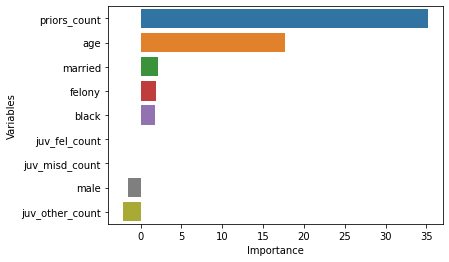

In [9]:
g = IntergroupDifference(group=X_test['black'], distance=fp_diff)
explainer = gshap.KernelExplainer(model.predict, X_train, g)
gshap_values = explainer.gshap_values(X_test, nsamples=10)
df = pd.DataFrame({'Variables': X.columns, 'Importance': 100*gshap_values})
df = df.sort_values('Importance', ascending=False)
sns.barplot(y='Variables', x='Importance', data=df)
print(gshap_values, gshap_values.sum())

In [10]:
model = Model(clf, t=.047)
Metrics(model, X_train, y_train).report()

Overall accuracy: 0.6704
Accuracy for Blacks: 0.6906
Accuracy for Whites: 0.6455
AUC: 0.7323

Confusion matrix for Blacks
[[0.64088889 0.35911111]
 [0.27284595 0.72715405]]

Confusion matrix for Whites
[[0.63721325 0.36278675]
 [0.3445122  0.6554878 ]]

Difference in false positive rate: -0.0101
p=0.8544


In [11]:
Metrics(model, X_test, y_test).report()

Overall accuracy: 0.6787
Accuracy for Blacks: 0.7037
Accuracy for Whites: 0.6461
AUC: 0.7291

Confusion matrix for Blacks
[[0.6377551  0.3622449 ]
 [0.24612403 0.75387597]]

Confusion matrix for Whites
[[0.63588391 0.36411609]
 [0.34169279 0.65830721]]

Difference in false positive rate: -0.0051
p=0.9570


[-0.01616597  0.11467263  0.          0.         -0.01026093  0.16007067
  0.00132031 -0.30323016  0.01246899] -0.04112445656527185


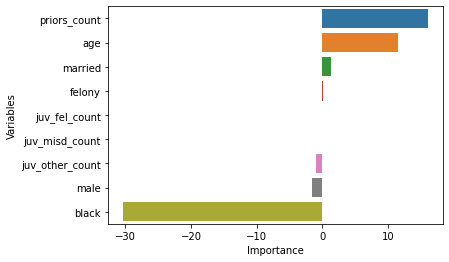

In [12]:
g = IntergroupDifference(group=X_test['black'], distance=fp_diff)
explainer = gshap.KernelExplainer(model.predict, X_train, g)
gshap_values = explainer.gshap_values(X_test, nsamples=10)
df = pd.DataFrame({'Variables': X.columns, 'Importance': 100*gshap_values})
df = df.sort_values('Importance', ascending=False)
sns.barplot(y='Variables', x='Importance', data=df)
print(gshap_values, gshap_values.sum())

In [13]:
X_test.head()

,male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,felony,black,married
1916,0,35,0,0,0,2,1,1,0
1096,1,24,0,0,0,1,1,0,0
2894,1,26,0,1,3,14,1,1,0
733,1,30,0,0,0,1,1,0,0
2210,1,29,0,2,0,12,1,1,0


[-0.01760926 -0.10937452  0.          0.         -0.00502095 -0.03957073
  0.01282353 -0.02894709  0.00231275] -0.18538627945184707


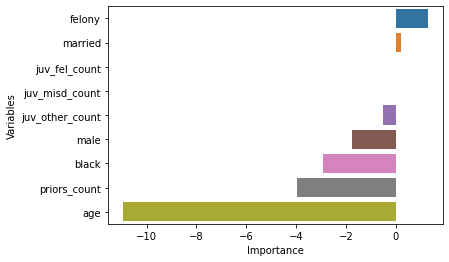

In [14]:
x = X_test.values[0].reshape(1, -1)
explainer = gshap.KernelExplainer(model.predict_proba, X_train)
gshap_values = explainer.gshap_values(x, nsamples=100)
df = pd.DataFrame({'Variables': X.columns, 'Importance': 100*gshap_values})
df = df.sort_values('Importance', ascending=False)
sns.barplot(y='Variables', x='Importance', data=df)
print(gshap_values, gshap_values.sum())

In [15]:
explainer.compare(x)

(0.33281384575366973, 0.517697230503082)

In [41]:
y_train.mean()

0.5222083852220839

In [17]:
df = X_train.describe()
df

,male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,felony,black,married
count,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000
mean,0.814031,29.855749,0.081777,0.113325,0.140307,3.481112,0.656496,0.551474,0.087796
std,0.389122,6.891441,0.525809,0.542969,0.567830,4.709559,0.474927,0.497395,0.283027
min,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,29.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000
75%,1.000000,35.000000,0.000000,0.000000,0.000000,5.000000,1.000000,1.000000,0.000000
max,1.000000,46.000000,20.000000,13.000000,17.000000,38.000000,1.000000,1.000000,1.000000


In [39]:
idx = list(X_test.sample(5).index)
idx

[843, 3803, 5106, 1607, 1171]

In [46]:
y_test[y_test.index.isin(idx)]

1171    0
1607    0
843     1
3803    1
5106    1
Name: two_year_recid, dtype: int64

In [54]:
from random import choices

idx = choices(list(range(len(X_test))), k=5)
X_sample = X_test.iloc[idx]
X_sample

,male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,felony,black,married
4091,1,27,0,0,0,0,0,0,1
695,1,34,0,0,0,1,0,1,0
1231,1,26,0,0,0,3,1,0,0
2616,1,44,0,0,0,1,1,0,0
233,1,35,0,0,0,0,1,1,1


In [55]:
y_sample = y_test.iloc[idx]
y_sample

4091    0
695     0
1231    1
2616    1
233     0
Name: two_year_recid, dtype: int64

In [57]:
list(y_sample)

[0, 0, 1, 1, 0]

In [59]:
y_test = pd.read_csv('y_test.csv')
y_test.head()

,two_year_recid
0,0
1,1
2,1
3,1
4,1


In [60]:
from random import choices

idx = choices(list(range(len(X))), k=5)
idx

[3617, 1622, 2261, 3515, 3215]

In [62]:
y_sample = y.iloc[idx]
y_sample

3617    0
1622    0
2261    1
3515    0
3215    0
Name: two_year_recid, dtype: int64

In [63]:
list(y_sample)

[0, 0, 1, 0, 0]